In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import os
import imutils

from scipy import ndimage as ndi
from scipy.spatial.distance import euclidean
from skimage.morphology import watershed, disk
from skimage.feature import peak_local_max


In [2]:
def fi_list(path):
    """
    Return a sorted list of filenames in a given path
    """
    return sorted([os.path.join(path, f) for f in os.listdir(path)])

def highlight_labels(img, labels):
    image = img.copy()
    
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] in labels:
                image[r,c] = 255
            else:
                image[r,c] = 0
                
    return image

def masks_to_binary(img):
    image = img.copy()
    
    for r in range(image.shape[0]):
        for c in range(image.shape[1]):
            if image[r,c] != 0:
                image[r,c] = 1
                
    return image

def equalize_clahe(img):
    image = img.copy()
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    return clahe.apply(image)

def disk_erode(img, radius=24, iters=1):
    image = img.copy()
    kern_disk = disk(radius)
    eroded = cv2.erode(image, kern_disk, iterations=iters)
    
    return eroded

def get_min_dist_marker(cell_mask, x, y, label):
    image = cell_mask.copy()
    
    min_dist = 9999999999
    
    #coords is list of coordinates of pixels that have their values as param:label
    coords = np.argwhere(image == label)
    
    dists = np.sqrt((coords[:,0] - x) ** 2 + (coords[:,1] - y) ** 2)
    
    min_dist_index = np.argmin(dists)
                   
    return (dists[min_dist_index])

def get_pixel_weight(cell_mask, x, y):
# from equation (1) in https://is.muni.cz/www/svoboda/ISBI-final.pdf
    #constants
    A = 0.004
    B = 40

    sigma_phi = 0
    
    for label in np.unique(cell_mask):
        min_dist_marker = get_min_dist_marker(cell_mask, x, y, label)
        
        sigma_phi += ( max( (B - min_dist_marker) , 0 ) ) ** 2
    
    print( 1 + (A * sigma_phi) )
        
    return ( 1 + (A * sigma_phi) )

In [7]:
def get_origs(path="DIC-2/01"):
    origs = []
    
    for filename in fi_list(path):
        if not filename.endswith(".tif"):
            continue
        
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        
        origs.append(image)
        
    return np.array(origs)

def get_clahes(origs):
    clahes = []
    
    for orig in origs:
        clahed = equalize_clahe(orig)
        clahes.append(clahed)
    
    return np.array(clahes)

def get_cell_masks(path="DIC-2/01_ST/SEG"):
    cell_masks = []
    
    #debug
    count = 0
    for filename in fi_list(path):
        if not filename.endswith(".tif"):
            continue
        
        image = cv2.imread(filename, cv2.IMREAD_UNCHANGED)
        
        cell_masks.append(image)
        
        #debug
        count+=1
        if count > 5:
            break
        
    return np.array(cell_masks)

def get_bin_cell_masks(cell_masks):
    bin_cell_masks = []
    
    for cell_mask in cell_masks:
        bin_c_m = masks_to_binary(cell_mask)
        bin_cell_masks.append(bin_c_m)
    
    return np.array(bin_cell_masks)

def get_cell_markers(cell_masks):
    cell_markers = []
    
    for mask in cell_masks:
        eroded = disk_erode(mask)
        cell_markers.append(eroded)
        
    return np.array(cell_markers)

def get_weight_maps(cell_markers):
#TODO: algorithm is implemented but not tested. Currently takes too long to run for even one picture
#      Optimize    
    weight_maps = []
    
    for cell_marker in cell_markers:
        image = cell_marker.copy()
        
        #debug
        count = 0
        
        for r in range(cell_marker.shape[0]):
            for c in range(cell_marker.shape[1]):
                image[r,c] = get_pixel_weight(image, r, c)
                
                #debug
                print(count)
                count += 1
                
        weight_maps.append(image)
        
    return np.array(weight_maps)
        

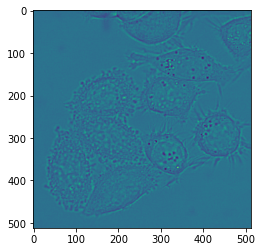

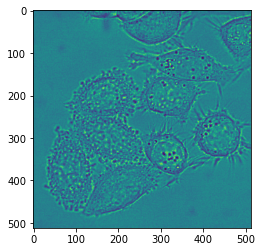

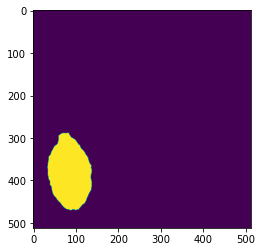

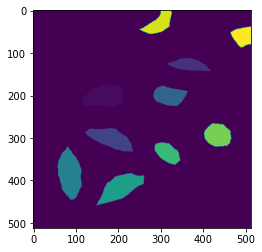

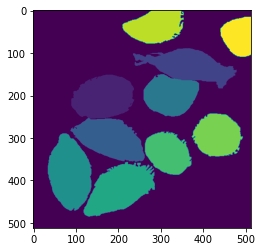

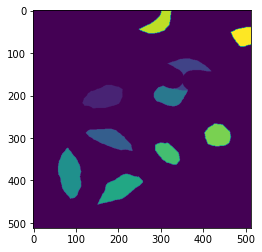

In [8]:
cell_masks = get_cell_masks()
origs = get_origs()
cell_markers = get_cell_markers(cell_masks)
# weight_maps = get_weight_maps(cell_markers)

a = origs[2]
b = get_clahes(origs)[2]
c = cell_masks[2]
d = cell_markers[2]

# h = weight_maps[2]


plt.imshow(a);
plt.show()

plt.imshow(b);
plt.show()

plt.imshow(highlight_labels(c, [15]));
plt.show()

plt.imshow(d);
plt.show()

plt.imshow(e);
plt.show()

plt.imshow(f);
plt.show()